# Jupyter Notebook Setup
***

## Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import warnings
from sklearn.exceptions import DataConversionWarning
import joblib
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Load Model & Data

In [2]:
## Load Model & Data
model = joblib.load('model.pkl')
test_data = pd.read_csv('student_data.csv')
test_data_with_gender = test_data.copy()

## Data Preprocessing

In [3]:
## Data Preprocessing
test_data = test_data.drop(columns=['Student ID', 'Gender'])

## Plot Distribution of Test Dataset

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_column(column):
    if test_data[column].dtype in ['int64', 'float64']:
        sns.histplot(data=test_data, x=column, kde=True)
    else:
        plot = sns.countplot(data=test_data, x=column)
        plt.xticks(rotation=45, ha='right')  # This line rotates the x-labels
    plt.show()

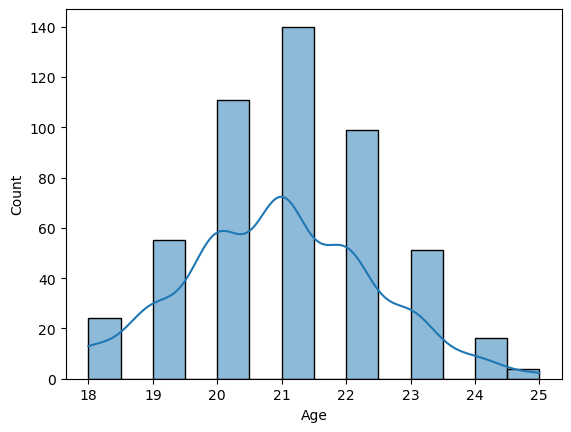

In [5]:
plot_column('Age')

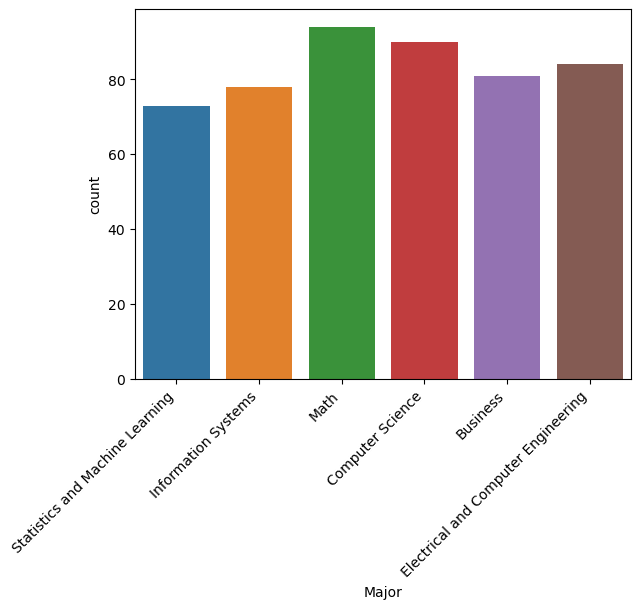

In [6]:
plot_column('Major')

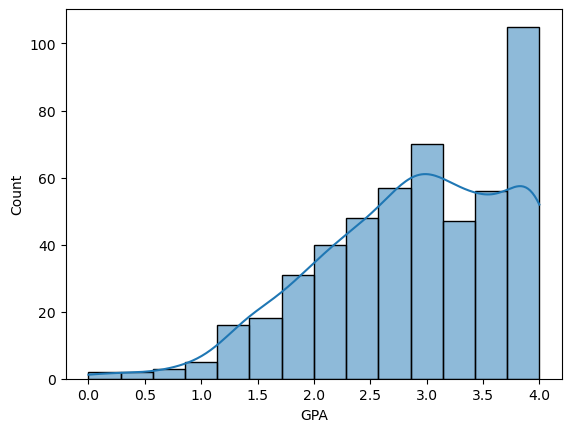

In [7]:
plot_column('GPA')

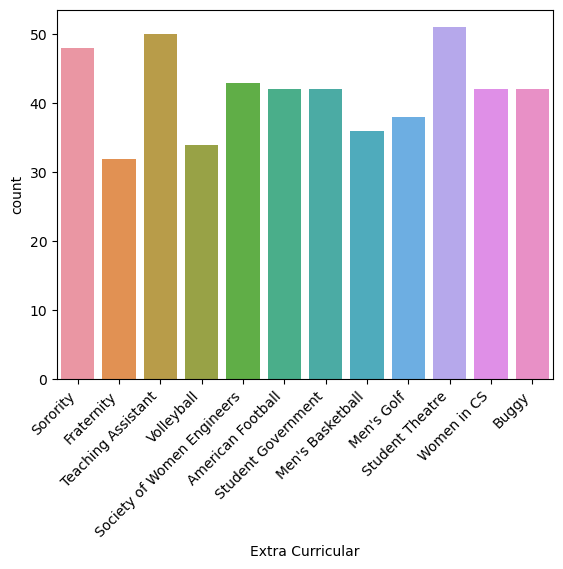

In [8]:
plot_column('Extra Curricular')

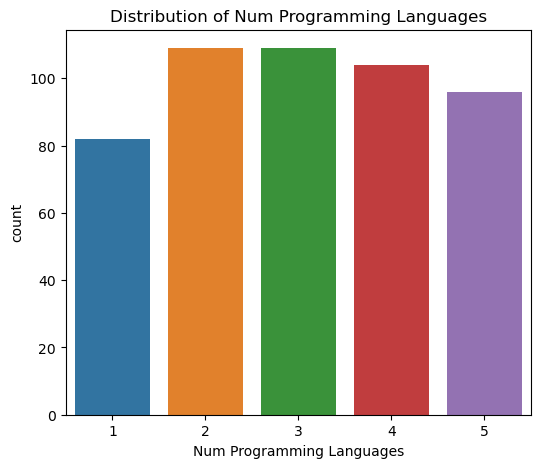

In [18]:
test_data_for_plotting = test_data_with_gender.drop(columns=["Student ID"])

feature = "Num Programming Languages"

plt.figure(figsize=(6, 5))
sns.countplot(data=test_data_for_plotting, x=feature)
plt.title(f"Distribution of {feature}")
plt.show()

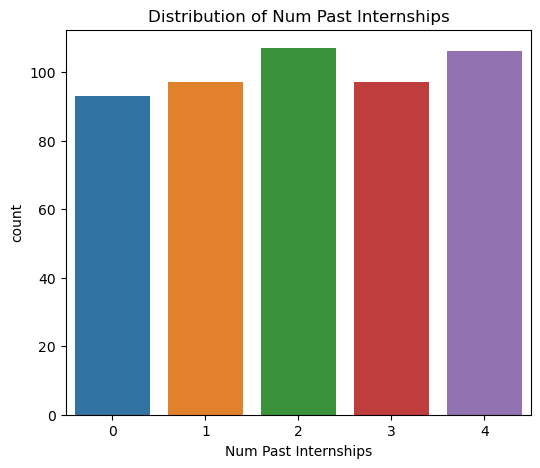

In [19]:
feature = "Num Past Internships"

plt.figure(figsize=(6, 5))
sns.countplot(data=test_data_for_plotting, x=feature)
plt.title(f"Distribution of {feature}")
plt.show()

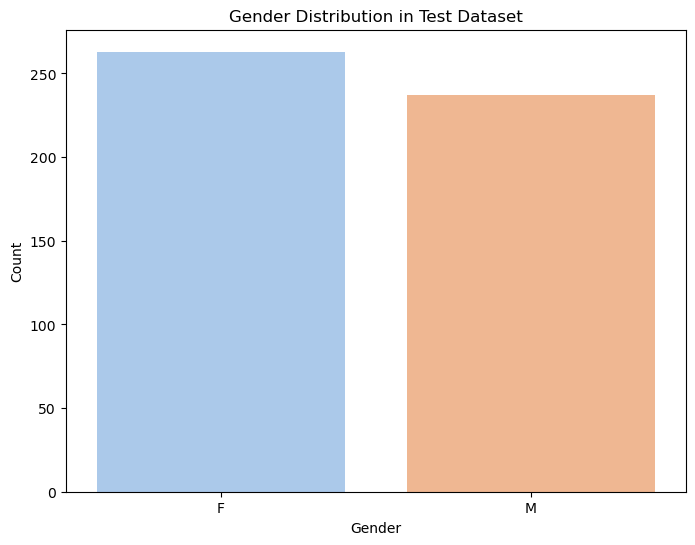

In [20]:
# Code that creates a count plot for the "Gender" feature
plt.figure(figsize=(8, 6))
sns.countplot(data=test_data_with_gender, x="Gender", palette="pastel")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution in Test Dataset")
plt.show()

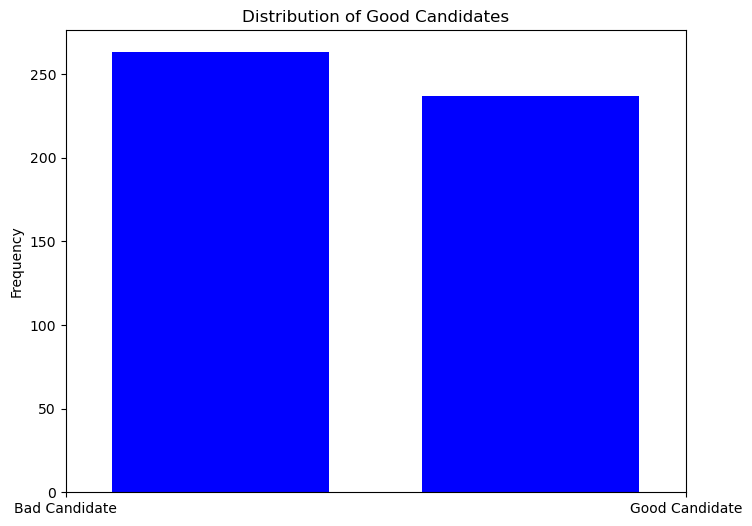

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(test_data_for_plotting["Good Candidate"], bins=[0, 0.5, 1], color="blue", rwidth=0.7)

plt.ylabel("Frequency")
plt.title("Distribution of Good Candidates")
plt.xticks([0, 1], labels=["Bad Candidate", "Good Candidate"])

plt.show()

## Predict the Output of Test Dataset

In [24]:
## Predict the Output of Test Dataset
X_test = test_data.drop(columns=['Good Candidate'])  
predictions = model.predict(X_test)

# Model Performance & Fairness
***

## Performance Evaluation
We have previously assessed the model's basic performance. Now, we'll conduct a more comprehensive evaluation.

### Accuracy and Confusion Matrix
First, we re-examine the model's accuracy and the confusion matrix on the test dataset.

In [25]:
import pandas as pd
## Accuracy and Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix

y_true = test_data['Good Candidate']  

# Accuracy
accuracy = accuracy_score(y_true, predictions)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, predictions)

In [26]:
# Accuracy and Confusion Matrix have already been calculated above
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 83.20%
Confusion Matrix:
[[221  42]
 [ 42 195]]


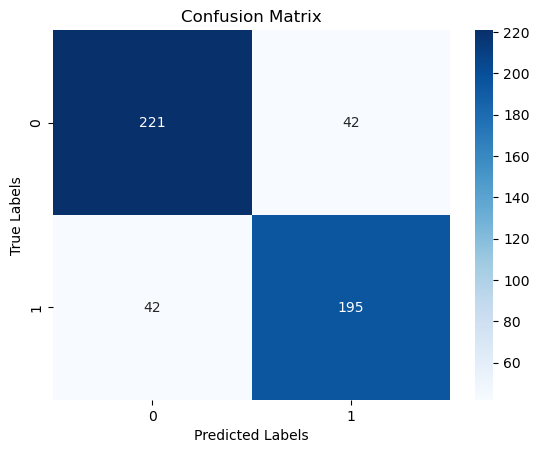

In [27]:
# Visualizing the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Precision, Recall, and F1-Score

We'll analyze the model's precision, recall, and F1-score to understand its performance in terms of false positives and false negatives.


In [28]:
# Classification Report
report = classification_report(y_true, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       263
           1       0.82      0.82      0.82       237

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



### ROC Curve and AUC

The ROC curve and AUC are useful for evaluating the performance of a binary classifier. We plot these to understand the trade-off between the true positive rate and false positive rate at various thresholds.


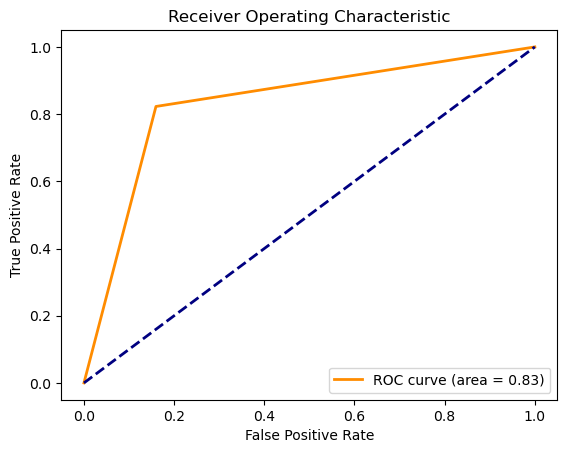

In [29]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve

For imbalanced datasets, the precision-recall curve is a more appropriate metric than the ROC curve. It shows the trade-off between precision and recall for different thresholds.


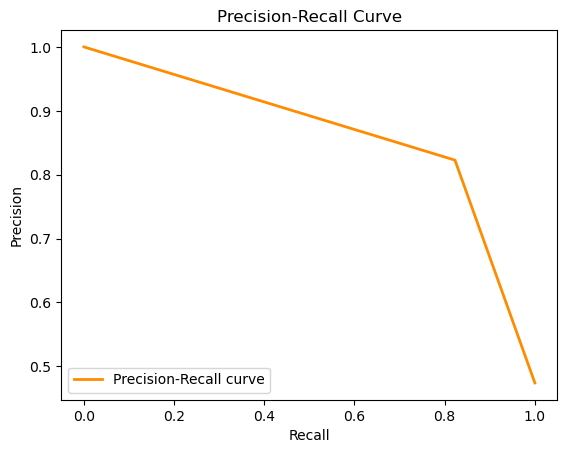

In [30]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, predictions)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Fairness Evaluation

In this section, we delve into evaluating the fairness of our machine learning model. Given the model's use in recruitment, it's crucial to ensure that it does not perpetuate or amplify biases. We will revisit the assumptions made by the previous engineer, discuss fairness in the context of machine learning, and apply several fairness metrics to evaluate our model.

### Revisiting Assumptions

The model was initially designed to be group unaware by excluding gender and student ID. However, this alone does not guarantee fairness. Other features might still correlate with sensitive attributes, leading to indirect biases.


### Fairness Discussion Recap

Reflecting on our in-class discussions and learnings from ML Discrimination, we understand that fairness in machine learning can be multifaceted. We need to consider various definitions and measures of fairness, such as equality of opportunity, predictive parity, and individual fairness, and how they apply to our context.

### Fairness Strategies and Metrics

We will evaluate our model using several fairness strategies and corresponding metrics:

1. **Equality of Opportunity**
2. **Predictive Parity**
3. **Group Unaware**
4. **Demographic Parity**
5. **Equalized odds**

Let's implement these evaluations step-by-step.


### Equality of Opportunity
This will compare the True Positive Rate between different groups.

In [31]:
# Add predictions back to data with gender
test_data_with_gender['Predictions'] = predictions

# Calculate true positive rates
tpr_gender = test_data_with_gender[test_data_with_gender['Good Candidate'] == 1].groupby('Gender')['Predictions'].mean()

print("\nTrue Positive Rates by Gender:")
print(tpr_gender)


True Positive Rates by Gender:
Gender
F    0.735537
M    0.913793
Name: Predictions, dtype: float64


In [32]:
# Calculate true positive rates for different age groups
tpr_age = test_data_with_gender[test_data_with_gender['Good Candidate'] == 1].groupby('Age')['Predictions'].mean()

print("\nTrue Positive Rates by Age:")
print(tpr_age)


True Positive Rates by Age:
Age
18    0.818182
19    0.869565
20    0.720000
21    0.892857
22    0.891304
23    0.875000
24    0.666667
25    0.250000
Name: Predictions, dtype: float64


In [33]:
# Calculate true positive rates for different majors
tpr_major = test_data_with_gender[test_data_with_gender['Good Candidate'] == 1].groupby('Major')['Predictions'].mean()

print("\nTrue Positive Rates by Major:")
print(tpr_major)


True Positive Rates by Major:
Major
Business                               0.875000
Computer Science                       0.837838
Electrical and Computer Engineering    0.775000
Information Systems                    0.756098
Math                                   0.844444
Statistics and Machine Learning        0.852941
Name: Predictions, dtype: float64


### Predictive Parity
Predictive Parity involves comparing the precision (Positive Predictive Value) between groups.

In [34]:
from sklearn.metrics import precision_score
# Calculate precision for each gender
precision_gender = test_data_with_gender.groupby('Gender').apply(
    lambda x: precision_score(x['Good Candidate'], x['Predictions'], zero_division=0)
)

print("\nPrecision by Gender:")
print(precision_gender)


Precision by Gender:
Gender
F    0.978022
M    0.726027
dtype: float64


In [35]:
# Calculate precision for each age group
precision_age = test_data_with_gender.groupby('Age').apply(
    lambda x: precision_score(x['Good Candidate'], x['Predictions'], zero_division=0)
)

print("\nPrecision by Age:")
print(precision_age)


Precision by Age:
Age
18    0.900000
19    0.909091
20    0.782609
21    0.833333
22    0.732143
23    0.875000
24    1.000000
25    1.000000
dtype: float64


In [36]:
# Calculate precision for each major
precision_major = test_data_with_gender.groupby('Major').apply(
    lambda x: precision_score(x['Good Candidate'], x['Predictions'], zero_division=0)
)

print("\nPrecision by Major:")
print(precision_major)


Precision by Major:
Major
Business                               0.897436
Computer Science                       0.775000
Electrical and Computer Engineering    0.861111
Information Systems                    0.794872
Math                                   0.844444
Statistics and Machine Learning        0.763158
dtype: float64


### Group Unaware

This approach assesses whether the model is group unaware with respect to certain features. A group unaware model does not use sensitive attributes (like gender, race) as input features during training. This is crucial to ensure that the model does not perpetuate or amplify biases based on these attributes.


In [37]:
is_gender_used = 'Gender' in X_test.columns
group_unaware_status = "Group Unaware" if not is_gender_used else "Group Aware"
print(f"The model is {group_unaware_status} with respect to Gender.")

The model is Group Unaware with respect to Gender.


In [38]:
is_age_used = 'Age' in X_test.columns
group_unaware_status_age = "Group Unaware" if not is_age_used else "Group Aware"
print(f"The model is {group_unaware_status_age} with respect to Age.")

The model is Group Aware with respect to Age.


In [39]:
is_major_used = 'Major' in X_test.columns
group_unaware_status_major = "Group Unaware" if not is_major_used else "Group Aware"
print(f"The model is {group_unaware_status_major} with respect to Major.")

The model is Group Aware with respect to Major.


### Demographic Parity

Demographic Parity is achieved when the decision outcome is independent of a given sensitive attribute. This means that each group (e.g., different genders) should have an equal probability of being predicted as a positive outcome. We calculate the positive rates for each group and compare them.


In [40]:
# Calculate positive rates by sensitive group (e.g., Gender)
positive_rates = test_data_with_gender.groupby('Gender')['Good Candidate'].mean()
print("Positive Rates by Gender:")
print(positive_rates)

# Check for Demographic Parity
demographic_parity = positive_rates.max() - positive_rates.min()
print("\nDemographic Parity Difference:")
print(demographic_parity)


Positive Rates by Gender:
Gender
F    0.460076
M    0.489451
Name: Good Candidate, dtype: float64

Demographic Parity Difference:
0.029375431165872545


In [41]:
# Calculate positive rates by age group
positive_rates_age = test_data_with_gender.groupby('Age')['Good Candidate'].mean()
print("Positive Rates by Age:")
print(positive_rates_age)

# Check for Demographic Parity in Age
demographic_parity_age = positive_rates_age.max() - positive_rates_age.min()
print("\nDemographic Parity Difference (Age):")
print(demographic_parity_age)

Positive Rates by Age:
Age
18    0.458333
19    0.418182
20    0.450450
21    0.400000
22    0.464646
23    0.627451
24    0.937500
25    1.000000
Name: Good Candidate, dtype: float64

Demographic Parity Difference (Age):
0.6


In [42]:
# Calculate positive rates by major
positive_rates_major = test_data_with_gender.groupby('Major')['Good Candidate'].mean()
print("Positive Rates by Major:")
print(positive_rates_major)

# Check for Demographic Parity in Major
demographic_parity_major = positive_rates_major.max() - positive_rates_major.min()
print("\nDemographic Parity Difference (Major):")
print(demographic_parity_major)

Positive Rates by Major:
Major
Business                               0.493827
Computer Science                       0.411111
Electrical and Computer Engineering    0.476190
Information Systems                    0.525641
Math                                   0.478723
Statistics and Machine Learning        0.465753
Name: Good Candidate, dtype: float64

Demographic Parity Difference (Major):
0.11452991452991457


### Equalized Odds

Equalized Odds is a fairness criterion that is satisfied when the model's predictions are conditionally independent of the sensitive attribute, given the true outcome. This means that the model should have equal true positive rates and false positive rates across different groups.


In [43]:
# Calculate True Positive Rates by Gender
tpr_gender = test_data_with_gender[test_data['Good Candidate'] == 1].groupby('Gender')['Predictions'].mean()
print("\nTrue Positive Rates by Gender:")
print(tpr_gender)

# Calculate False Positive Rates by Gender
fpr_gender = test_data_with_gender[test_data['Good Candidate'] == 0].groupby('Gender')['Predictions'].mean()
print("\nFalse Positive Rates by Gender:")
print(fpr_gender)


True Positive Rates by Gender:
Gender
F    0.735537
M    0.913793
Name: Predictions, dtype: float64

False Positive Rates by Gender:
Gender
F    0.014085
M    0.330579
Name: Predictions, dtype: float64


In [44]:
# Calculate True Positive Rates by Age
tpr_age = test_data_with_gender[test_data['Good Candidate'] == 1].groupby('Age')['Predictions'].mean()
print("\nTrue Positive Rates by Age:")
print(tpr_age)

# Calculate False Positive Rates by Age
fpr_age = test_data_with_gender[test_data['Good Candidate'] == 0].groupby('Age')['Predictions'].mean()
print("\nFalse Positive Rates by Age:")
print(fpr_age)


True Positive Rates by Age:
Age
18    0.818182
19    0.869565
20    0.720000
21    0.892857
22    0.891304
23    0.875000
24    0.666667
25    0.250000
Name: Predictions, dtype: float64

False Positive Rates by Age:
Age
18    0.076923
19    0.062500
20    0.163934
21    0.119048
22    0.283019
23    0.210526
24    0.000000
Name: Predictions, dtype: float64


In [45]:
# Calculate True Positive Rates by Major
tpr_major = test_data_with_gender[test_data['Good Candidate'] == 1].groupby('Major')['Predictions'].mean()
print("\nTrue Positive Rates by Major:")
print(tpr_major)

# Calculate False Positive Rates by Major
fpr_major = test_data_with_gender[test_data['Good Candidate'] == 0].groupby('Major')['Predictions'].mean()
print("\nFalse Positive Rates by Major:")
print(fpr_major)


True Positive Rates by Major:
Major
Business                               0.875000
Computer Science                       0.837838
Electrical and Computer Engineering    0.775000
Information Systems                    0.756098
Math                                   0.844444
Statistics and Machine Learning        0.852941
Name: Predictions, dtype: float64

False Positive Rates by Major:
Major
Business                               0.097561
Computer Science                       0.169811
Electrical and Computer Engineering    0.113636
Information Systems                    0.216216
Math                                   0.142857
Statistics and Machine Learning        0.230769
Name: Predictions, dtype: float64
